# Crossover Design - 3-Way Active Speaker System

This notebook analyzes crossover points and filter design for the active 3-way speaker system using DSP processing.

## System Configuration (from README.md)
- **Subwoofers**: 2× Tang Band W3-1876S (32-240 Hz bandpass)
- **Midrange**: 1× Tang Band W3-871SC (240-2500 Hz bandpass)
- **Tweeter**: 1× Scan-Speak D2608/913000 (2500+ Hz highpass)
- **DSP**: ADAU1701 with 24 dB/octave Linkwitz-Riley filters
- **Amplifier**: TPA3255 (4-channel, 50W each @ 8Ω)

In [6]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy import signal
import warnings
warnings.filterwarnings('ignore')

# Set up plotting style
plt.style.use('seaborn-v0_8')
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 12

print("✅ Libraries imported successfully")

✅ Libraries imported successfully


## 1. System Specifications from README.md

In [7]:
# Driver specifications from README.md
drivers = {
    'subwoofer': {
        'name': 'Tang Band W3-1876S',
        'quantity': 2,
        'sensitivity': 76.0,  # dB @ 2.83V/1m (individual)
        'sensitivity_dual': 82.0,  # +6dB for dual drivers
        'impedance': 4,  # Ω (each driver)
        'impedance_config': '2×4Ω on separate channels',
        'fs': 55,  # Hz
        'freq_range': (20, 240),  # Hz - usage in system
        'power_max': 60,  # W total (30W each)
        'enclosure': 'Transmission line (1.98m, 42Hz tuning)',
        'features': ['5mm Xmax', 'TL enclosure', 'Separate amp channels']
    },
    'midrange': {
        'name': 'Tang Band W3-871SC',
        'quantity': 1,
        'sensitivity': 87.0,  # dB @ 2.83V/1m
        'impedance': 8,  # Ω
        'fs': 87,  # Hz (from README)
        'freq_range': (240, 2500),  # Hz - usage in system
        'power_max': 25,  # W
        'enclosure': 'Sealed (1.2L, Qtc=0.90)',
        'features': ['Full-range capability', 'Sealed enclosure']
    },
    'tweeter': {
        'name': 'Scan-Speak D2608/913000',
        'quantity': 1,
        'sensitivity': 91.3,  # dB @ 2.83V/1m
        'impedance': 8,  # Ω
        'fs': 700,  # Hz
        'freq_range': (2500, 20000),  # Hz - usage in system
        'crossover_min': 1500,  # Hz - minimum safe crossover
        'power_max': 25,  # W (estimated)
        'enclosure': 'Sealed rear pod (0.06L)',
        'features': ['Danish manufacture', 'Textile dome', 'Ferrofluid']
    }
}

# Crossover frequencies from README.md
crossover_frequencies = {
    'subsonic': 32,     # Hz - High-pass for driver protection
    'sub_to_mid': 240,  # Hz - Sub/Mid crossover
    'mid_to_tweet': 2500  # Hz - Mid/Tweet crossover (2.5 kHz)
}

# Filter specifications
filter_spec = {
    'type': 'Linkwitz-Riley',
    'order': 4,  # 4th order
    'slope': 24,  # dB/octave
    'sample_rate': 48000  # Hz (ADAU1701)
}

# Gain structure from README.md
gain_structure = {
    'subwoofer': 10,   # dB boost
    'midrange': 0,     # dB (reference)
    'tweeter': -2,     # dB attenuation
    'limiter': {
        'threshold': -1,  # dBFS
        'attack': 1,      # ms
        'release': 100    # ms
    }
}

# System specifications
system_spec = {
    'amplifier': 'TPA3255 4-channel',
    'channels': 4,
    'power_per_channel': 50,  # W @ 8Ω (100W @ 4Ω)
    'dsp': 'ADAU1701',
    'topology': 'Mono (all drivers sum L+R)',
    'channel_assignment': {
        'ch1': 'Subwoofer 1 (4Ω)',
        'ch2': 'Subwoofer 2 (4Ω)',
        'ch3': 'Midrange (8Ω)',
        'ch4': 'Tweeter (8Ω)'
    }
}

print("🔊 3-WAY ACTIVE SPEAKER SYSTEM SPECIFICATIONS")
print("=" * 60)

for driver_type, specs in drivers.items():
    print(f"\n{driver_type.upper()}:")
    print(f"   • Driver: {specs['name']}")
    print(f"   • Quantity: {specs['quantity']}")
    print(f"   • Sensitivity: {specs['sensitivity']} dB" + 
          (f" (dual: {specs['sensitivity_dual']} dB)" if 'sensitivity_dual' in specs else ""))
    print(f"   • Impedance: {specs['impedance']} Ω" + 
          (f" ({specs['impedance_config']})" if 'impedance_config' in specs else ""))
    print(f"   • Frequency range: {specs['freq_range'][0]}-{specs['freq_range'][1]:,} Hz")
    print(f"   • Power handling: {specs['power_max']} W")
    print(f"   • Enclosure: {specs['enclosure']}")

print(f"\n🎛️ CROSSOVER DESIGN:")
print(f"   • Subsonic filter: {crossover_frequencies['subsonic']} Hz HP")
print(f"   • Sub → Mid: {crossover_frequencies['sub_to_mid']} Hz")
print(f"   • Mid → Tweet: {crossover_frequencies['mid_to_tweet']} Hz")
print(f"   • Filter type: {filter_spec['type']} {filter_spec['order']}th order")
print(f"   • Filter slope: {filter_spec['slope']} dB/octave")

print(f"\n⚡ AMPLIFICATION:")
print(f"   • Amplifier: {system_spec['amplifier']}")
print(f"   • Power: {system_spec['power_per_channel']}W/ch @ 8Ω")
print(f"   • DSP: {system_spec['dsp']} @ {filter_spec['sample_rate']:,} Hz")

print(f"\n📡 CHANNEL ROUTING:")
for ch, assignment in system_spec['channel_assignment'].items():
    print(f"   • {ch.upper()}: {assignment}")

🔊 3-WAY ACTIVE SPEAKER SYSTEM SPECIFICATIONS

SUBWOOFER:
   • Driver: Tang Band W3-1876S
   • Quantity: 2
   • Sensitivity: 76.0 dB (dual: 82.0 dB)
   • Impedance: 4 Ω (2×4Ω on separate channels)
   • Frequency range: 20-240 Hz
   • Power handling: 60 W
   • Enclosure: Transmission line (1.98m, 42Hz tuning)

MIDRANGE:
   • Driver: Tang Band W3-871SC
   • Quantity: 1
   • Sensitivity: 87.0 dB
   • Impedance: 8 Ω
   • Frequency range: 240-2,500 Hz
   • Power handling: 25 W
   • Enclosure: Sealed (1.2L, Qtc=0.90)

TWEETER:
   • Driver: Scan-Speak D2608/913000
   • Quantity: 1
   • Sensitivity: 91.3 dB
   • Impedance: 8 Ω
   • Frequency range: 2500-20,000 Hz
   • Power handling: 25 W
   • Enclosure: Sealed rear pod (0.06L)

🎛️ CROSSOVER DESIGN:
   • Subsonic filter: 32 Hz HP
   • Sub → Mid: 240 Hz
   • Mid → Tweet: 2500 Hz
   • Filter type: Linkwitz-Riley 4th order
   • Filter slope: 24 dB/octave

⚡ AMPLIFICATION:
   • Amplifier: TPA3255 4-channel
   • Power: 50W/ch @ 8Ω
   • DSP: ADAU1701

## 2. Load Real Measurement Data

In [8]:
# Load measurement data for visualization
import os

base_path = '../speakers/'
measurement_data = {}

# Driver folder mapping
driver_paths = {
    'subwoofer': 'TangBand W3-1876S',
    'midrange': 'TangBand W3-871SC', 
    'tweeter': 'ScanSpeak D20608-913000'
}

for driver_type, folder in driver_paths.items():
    freq_response_path = os.path.join(base_path, folder, 'Frequency Response.csv')
    
    if os.path.exists(freq_response_path):
        try:
            data = pd.read_csv(freq_response_path, header=None, names=['freq', 'spl'])
            measurement_data[driver_type] = {
                'freq': data['freq'].values,
                'spl': data['spl'].values
            }
            
            # For dual subwoofers, add 6dB
            if driver_type == 'subwoofer':
                measurement_data[driver_type]['spl_dual'] = data['spl'].values + 6
                
            print(f"✅ Loaded {driver_type} measurement data")
        except Exception as e:
            print(f"❌ Could not load {driver_type} data: {e}")
            measurement_data[driver_type] = None
    else:
        print(f"❌ No measurement data found for {driver_type}")
        measurement_data[driver_type] = None

print("\n📊 Measurement data loading complete")

✅ Loaded subwoofer measurement data
✅ Loaded midrange measurement data
✅ Loaded tweeter measurement data

📊 Measurement data loading complete


## 3. DSP Configuration

In [9]:
# DSP Configuration for ADAU1701
dsp_config = {
    'processor': 'ADAU1701',
    'sample_rate': 48000,  # Hz
    'bit_depth': '28/56-bit processing',
    'inputs': {
        'ADC0': 'Left Input',
        'ADC1': 'Right Input'
    },
    'outputs': {
        'DAC0': 'Subwoofer 1 (L+R sum)',
        'DAC1': 'Subwoofer 2 (L+R sum)',
        'DAC2': 'Midrange (L+R sum)', 
        'DAC3': 'Tweeter (L+R sum)'
    },
    'processing_blocks': {
        'input_gain': 'Adjustable input level control',
        'mixer': 'L+R sum for mono system',
        'eq': 'Parametric EQ for room correction',
        'crossover': '24 dB/oct Linkwitz-Riley filters',
        'delay': 'Time alignment compensation',
        'limiter': f'Driver protection ({gain_structure["limiter"]["threshold"]} dBFS, {gain_structure["limiter"]["attack"]}ms attack, {gain_structure["limiter"]["release"]}ms release)',
        'output_gain': 'Individual level control per driver'
    }
}

# Signal flow stages
signal_flow = {
    'stages': [
        {'name': 'Input', 'description': 'Stereo Line Input (L+R)'},
        {'name': 'Input Gain', 'description': 'Digital gain control'},
        {'name': 'L+R Mixer', 'description': 'Sum stereo to mono'},
        {'name': 'EQ', 'description': 'Room correction (optional)'},
        {'name': 'Crossover', 'description': '3-way frequency splitting'},
        {'name': 'Time Align', 'description': 'Driver delay compensation'},
        {'name': 'Limiters', 'description': 'Individual driver protection'},
        {'name': 'Output Gain', 'description': 'Individual level trim'},
        {'name': 'DAC Output', 'description': '4-channel analog output'}
    ]
}

# Filter specifications for each driver
filter_specs = {
    'subwoofer': {
        'type': 'Band-pass',
        'freq_high': crossover_frequencies['subsonic'],
        'freq_low': crossover_frequencies['sub_to_mid'],
        'order': f'{filter_spec["order"]}th order ({filter_spec["slope"]} dB/octave)',
        'topology': 'Linkwitz-Riley HP + LP',
        'gain': f'+{gain_structure["subwoofer"]} dB'
    },
    'midrange': {
        'type': 'Band-pass',
        'freq_low': crossover_frequencies['sub_to_mid'],
        'freq_high': crossover_frequencies['mid_to_tweet'],
        'order': f'{filter_spec["order"]}th order ({filter_spec["slope"]} dB/octave)',
        'topology': 'Linkwitz-Riley HP + LP',
        'gain': f'{gain_structure["midrange"]:+d} dB'
    },
    'tweeter': {
        'type': 'High-pass',
        'frequency': crossover_frequencies['mid_to_tweet'],
        'order': f'{filter_spec["order"]}th order ({filter_spec["slope"]} dB/octave)',
        'topology': 'Linkwitz-Riley (or 1024-tap FIR)',
        'gain': f'{gain_structure["tweeter"]:+d} dB'
    }
}

print("🖥️ DSP CONFIGURATION (ADAU1701):")
print("=" * 50)
print(f"Processor: {dsp_config['processor']}")
print(f"Sample Rate: {dsp_config['sample_rate']:,} Hz")
print(f"Processing: {dsp_config['bit_depth']}")
print()

print("📡 SIGNAL FLOW:")
for i, stage in enumerate(signal_flow['stages']):
    print(f"{i+1:2d}. {stage['name']:12} → {stage['description']}")

print("\n🎛️ FILTER SPECIFICATIONS:")
print("=" * 50)
for driver, specs in filter_specs.items():
    print(f"\n{driver.upper()}:")
    for param, value in specs.items():
        print(f"   • {param.replace('_', ' ').title()}: {value}")

print("\n🔧 GAIN STRUCTURE:")
print(f"   • Subwoofers: {gain_structure['subwoofer']:+d} dB boost")
print(f"   • Midrange: {gain_structure['midrange']} dB (reference)")  
print(f"   • Tweeter: {gain_structure['tweeter']:+d} dB attenuation")
print(f"   • Limiter: {gain_structure['limiter']['threshold']} dBFS threshold")
print(f"   • Attack/Release: {gain_structure['limiter']['attack']}ms / {gain_structure['limiter']['release']}ms")

🖥️ DSP CONFIGURATION (ADAU1701):
Processor: ADAU1701
Sample Rate: 48,000 Hz
Processing: 28/56-bit processing

📡 SIGNAL FLOW:
 1. Input        → Stereo Line Input (L+R)
 2. Input Gain   → Digital gain control
 3. L+R Mixer    → Sum stereo to mono
 4. EQ           → Room correction (optional)
 5. Crossover    → 3-way frequency splitting
 6. Time Align   → Driver delay compensation
 7. Limiters     → Individual driver protection
 8. Output Gain  → Individual level trim
 9. DAC Output   → 4-channel analog output

🎛️ FILTER SPECIFICATIONS:

SUBWOOFER:
   • Type: Band-pass
   • Freq High: 32
   • Freq Low: 240
   • Order: 4th order (24 dB/octave)
   • Topology: Linkwitz-Riley HP + LP
   • Gain: +10 dB

MIDRANGE:
   • Type: Band-pass
   • Freq Low: 240
   • Freq High: 2500
   • Order: 4th order (24 dB/octave)
   • Topology: Linkwitz-Riley HP + LP
   • Gain: +0 dB

TWEETER:
   • Type: High-pass
   • Frequency: 2500
   • Order: 4th order (24 dB/octave)
   • Topology: Linkwitz-Riley (or 1024-tap

## 4. Linkwitz-Riley Filter Design

In [10]:
def linkwitz_riley_filter(freq_array, fc, order=4, filter_type='low'):
    """
    Generate Linkwitz-Riley filter response
    order=4 gives 24 dB/octave slope
    """
    s = 1j * 2 * np.pi * freq_array
    wc = 2 * np.pi * fc
    
    if filter_type == 'low':
        # Low-pass Linkwitz-Riley
        H = (wc**order) / (s**order + np.sqrt(2)*wc*s**(order-1) + wc**order)
    else:
        # High-pass Linkwitz-Riley
        H = (s**order) / (s**order + np.sqrt(2)*wc*s**(order-1) + wc**order)
    
    # Convert to magnitude in dB
    magnitude_db = 20 * np.log10(np.abs(H))
    
    return magnitude_db

def create_crossover_filters(freq_array, fc_subsonic, fc_low, fc_high):
    """
    Create complete 3-way crossover filter set with subsonic filter
    """
    filters = {}
    
    # Subwoofer: Band-pass (HP at fc_subsonic, LP at fc_low)
    hp_subsonic = linkwitz_riley_filter(freq_array, fc_subsonic, order=4, filter_type='high')
    lp_sub = linkwitz_riley_filter(freq_array, fc_low, order=4, filter_type='low')
    filters['subwoofer'] = hp_subsonic + lp_sub
    
    # Midrange: Band-pass (HP at fc_low, LP at fc_high)
    hp_mid = linkwitz_riley_filter(freq_array, fc_low, order=4, filter_type='high')
    lp_mid = linkwitz_riley_filter(freq_array, fc_high, order=4, filter_type='low')
    filters['midrange'] = hp_mid + lp_mid
    
    # Tweeter: High-pass at fc_high
    filters['tweeter'] = linkwitz_riley_filter(freq_array, fc_high, order=4, filter_type='high')
    
    return filters

# Generate frequency array for filter analysis
freq_analysis = np.logspace(1, 5, 1000)  # 10 Hz to 100 kHz

# Create crossover filters
crossover_filters = create_crossover_filters(
    freq_analysis, 
    crossover_frequencies['subsonic'],
    crossover_frequencies['sub_to_mid'],
    crossover_frequencies['mid_to_tweet']
)

print(f"🎛️ LINKWITZ-RILEY CROSSOVER FILTERS GENERATED:")
print(f"   • Subwoofer: Band-pass {crossover_frequencies['subsonic']}-{crossover_frequencies['sub_to_mid']} Hz")
print(f"   • Midrange: Band-pass {crossover_frequencies['sub_to_mid']}-{crossover_frequencies['mid_to_tweet']} Hz")
print(f"   • Tweeter: High-pass @ {crossover_frequencies['mid_to_tweet']} Hz")
print(f"   • Filter order: {filter_spec['order']}th order ({filter_spec['slope']} dB/octave)")
print(f"   • Filter type: Linkwitz-Riley (perfect reconstruction)")

🎛️ LINKWITZ-RILEY CROSSOVER FILTERS GENERATED:
   • Subwoofer: Band-pass 32-240 Hz
   • Midrange: Band-pass 240-2500 Hz
   • Tweeter: High-pass @ 2500 Hz
   • Filter order: 4th order (24 dB/octave)
   • Filter type: Linkwitz-Riley (perfect reconstruction)


## 5. Crossover Analysis and Visualization

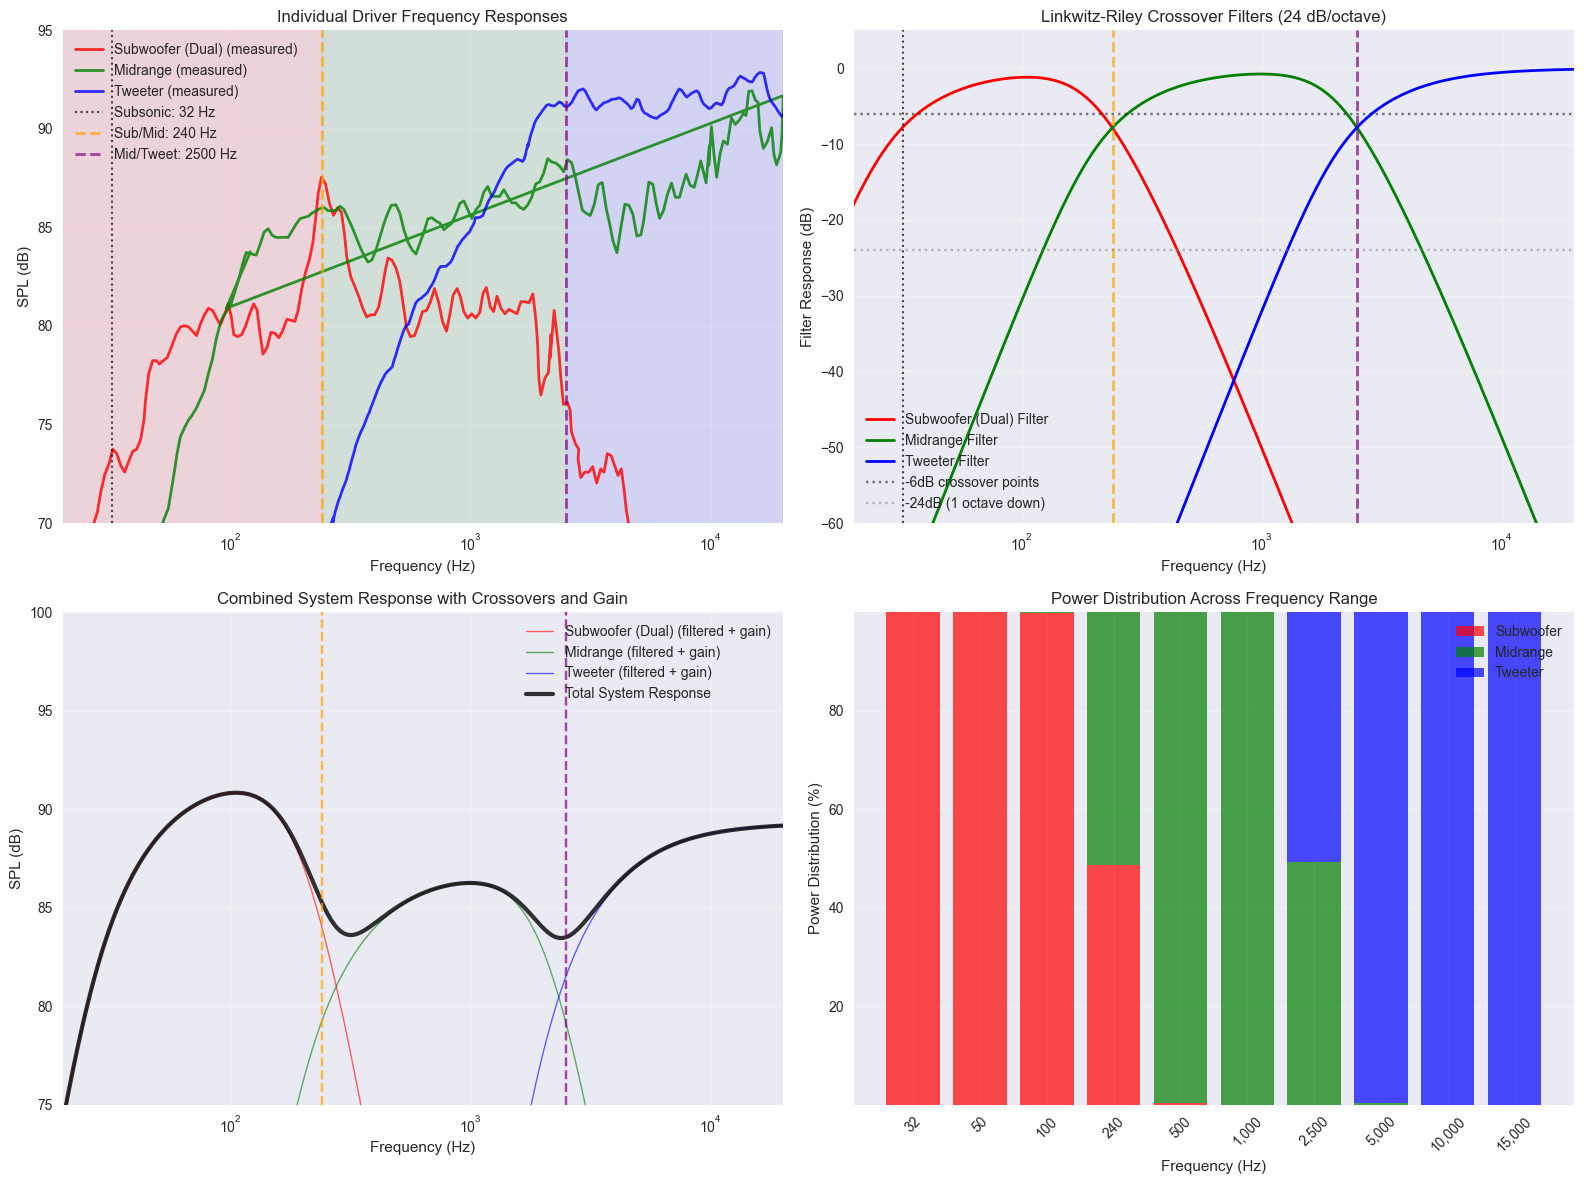


📊 CROSSOVER ANALYSIS SUMMARY:
Filter type: Linkwitz-Riley
Filter slope: 24 dB/octave
Crossover frequencies: 32, 240, 2500 Hz
Total system bandwidth: 20 Hz - 20 kHz

Frequency coverage per driver:
   • Subwoofer: 32-240 Hz (2.9 octaves)
   • Midrange: 240-2500 Hz (3.4 octaves)
   • Tweeter: 2500-20000 Hz (3.0 octaves)


In [11]:
# Create comprehensive crossover analysis plot
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16, 12))

# Color scheme
colors = {'subwoofer': 'red', 'midrange': 'green', 'tweeter': 'blue'}
driver_names = {'subwoofer': 'Subwoofer (Dual)', 'midrange': 'Midrange', 'tweeter': 'Tweeter'}

# 1. Individual Driver Responses with Measurement Data
for driver_type, color in colors.items():
    if measurement_data[driver_type] is not None:
        data = measurement_data[driver_type]
        if driver_type == 'subwoofer':
            ax1.semilogx(data['freq'], data['spl_dual'], color=color, linewidth=2, 
                        label=f"{driver_names[driver_type]} (measured)", alpha=0.8)
        else:
            ax1.semilogx(data['freq'], data['spl'], color=color, linewidth=2, 
                        label=f"{driver_names[driver_type]} (measured)", alpha=0.8)
    else:
        # Create theoretical response if no measurement data
        specs = drivers[driver_type]
        freq_range = np.logspace(np.log10(specs['freq_range'][0]), 
                                np.log10(specs['freq_range'][1]), 100)
        if driver_type == 'subwoofer':
            theoretical_spl = np.full_like(freq_range, specs['sensitivity_dual'])
        else:
            theoretical_spl = np.full_like(freq_range, specs['sensitivity'])
        ax1.semilogx(freq_range, theoretical_spl, color=color, linewidth=2, 
                    linestyle='--', label=f"{driver_names[driver_type]} (theoretical)", alpha=0.6)

# Add frequency range indicators
for driver_type, specs in drivers.items():
    freq_min, freq_max = specs['freq_range']
    ax1.axvspan(freq_min, freq_max, alpha=0.1, color=colors[driver_type])

# Add crossover lines
ax1.axvline(crossover_frequencies['subsonic'], color='black', linestyle=':', alpha=0.7, linewidth=1.5, label=f'Subsonic: {crossover_frequencies["subsonic"]} Hz')
ax1.axvline(crossover_frequencies['sub_to_mid'], color='orange', linestyle='--', alpha=0.7, linewidth=2, label=f'Sub/Mid: {crossover_frequencies["sub_to_mid"]} Hz')
ax1.axvline(crossover_frequencies['mid_to_tweet'], color='purple', linestyle='--', alpha=0.7, linewidth=2, label=f'Mid/Tweet: {crossover_frequencies["mid_to_tweet"]} Hz')

ax1.set_xlabel('Frequency (Hz)')
ax1.set_ylabel('SPL (dB)')
ax1.set_title('Individual Driver Frequency Responses')
ax1.legend()
ax1.grid(True, alpha=0.3)
ax1.set_xlim(20, 20000)
ax1.set_ylim(70, 95)

# 2. Crossover Filter Responses
for driver_type, color in colors.items():
    ax2.semilogx(freq_analysis, crossover_filters[driver_type], color=color, linewidth=2, 
                label=f"{driver_names[driver_type]} Filter")

# Add crossover frequency lines
ax2.axvline(crossover_frequencies['subsonic'], color='black', linestyle=':', alpha=0.7, linewidth=1.5)
ax2.axvline(crossover_frequencies['sub_to_mid'], color='orange', linestyle='--', alpha=0.7, linewidth=2)
ax2.axvline(crossover_frequencies['mid_to_tweet'], color='purple', linestyle='--', alpha=0.7, linewidth=2)
ax2.axhline(-6, color='black', linestyle=':', alpha=0.5, label='-6dB crossover points')
ax2.axhline(-24, color='gray', linestyle=':', alpha=0.5, label='-24dB (1 octave down)')

ax2.set_xlabel('Frequency (Hz)')
ax2.set_ylabel('Filter Response (dB)')
ax2.set_title('Linkwitz-Riley Crossover Filters (24 dB/octave)')
ax2.legend()
ax2.grid(True, alpha=0.3)
ax2.set_xlim(20, 20000)
ax2.set_ylim(-60, 5)

# 3. Combined System Response with Gain
total_response = np.zeros_like(freq_analysis)

for driver_type, color in colors.items():
    # Get driver sensitivity
    if driver_type == 'subwoofer':
        driver_sensitivity = drivers[driver_type]['sensitivity_dual']
    else:
        driver_sensitivity = drivers[driver_type]['sensitivity']
    
    # Add DSP gain
    driver_gain = gain_structure[driver_type]
    
    # Add filtered response to total
    filtered_response = driver_sensitivity + driver_gain + crossover_filters[driver_type]
    
    # Plot individual filtered responses
    ax3.semilogx(freq_analysis, filtered_response, color=color, linewidth=1, alpha=0.6,
                label=f"{driver_names[driver_type]} (filtered + gain)")
    
    # Add to total (linear addition of powers, then convert back to dB)
    total_response += 10**(filtered_response/10)

# Convert total back to dB
total_response_db = 10 * np.log10(total_response)
ax3.semilogx(freq_analysis, total_response_db, 'black', linewidth=3, 
            label='Total System Response', alpha=0.8)

ax3.axvline(crossover_frequencies['sub_to_mid'], color='orange', linestyle='--', alpha=0.7)
ax3.axvline(crossover_frequencies['mid_to_tweet'], color='purple', linestyle='--', alpha=0.7)

ax3.set_xlabel('Frequency (Hz)')
ax3.set_ylabel('SPL (dB)')
ax3.set_title('Combined System Response with Crossovers and Gain')
ax3.legend()
ax3.grid(True, alpha=0.3)
ax3.set_xlim(20, 20000)
ax3.set_ylim(75, 100)

# 4. Power Distribution Analysis
test_frequencies = [32, 50, 100, 240, 500, 1000, 2500, 5000, 10000, 15000]
power_distribution = {'frequency': [], 'subwoofer': [], 'midrange': [], 'tweeter': []}

for freq in test_frequencies:
    freq_idx = np.argmin(np.abs(freq_analysis - freq))
    
    power_distribution['frequency'].append(freq)
    
    # Calculate relative power for each driver (based on filter response)
    sub_power = 10**(crossover_filters['subwoofer'][freq_idx]/10)
    mid_power = 10**(crossover_filters['midrange'][freq_idx]/10)
    tweet_power = 10**(crossover_filters['tweeter'][freq_idx]/10)
    
    total_power = sub_power + mid_power + tweet_power
    
    power_distribution['subwoofer'].append(sub_power/total_power * 100)
    power_distribution['midrange'].append(mid_power/total_power * 100)
    power_distribution['tweeter'].append(tweet_power/total_power * 100)

# Create stacked bar chart
x_pos = np.arange(len(test_frequencies))
width = 0.8

ax4.bar(x_pos, power_distribution['subwoofer'], width, 
        label='Subwoofer', color='red', alpha=0.7)
ax4.bar(x_pos, power_distribution['midrange'], width, 
        bottom=power_distribution['subwoofer'], 
        label='Midrange', color='green', alpha=0.7)
ax4.bar(x_pos, power_distribution['tweeter'], width, 
        bottom=[s+m for s,m in zip(power_distribution['subwoofer'], power_distribution['midrange'])],
        label='Tweeter', color='blue', alpha=0.7)

ax4.set_xlabel('Frequency (Hz)')
ax4.set_ylabel('Power Distribution (%)')
ax4.set_title('Power Distribution Across Frequency Range')
ax4.set_xticks(x_pos)
ax4.set_xticklabels([f'{f:,}' for f in test_frequencies], rotation=45)
ax4.legend()
ax4.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

# Print analysis summary
print(f"\n📊 CROSSOVER ANALYSIS SUMMARY:")
print(f"=" * 50)
print(f"Filter type: {filter_spec['type']}")
print(f"Filter slope: {filter_spec['slope']} dB/octave")
print(f"Crossover frequencies: {crossover_frequencies['subsonic']}, {crossover_frequencies['sub_to_mid']}, {crossover_frequencies['mid_to_tweet']} Hz")
print(f"Total system bandwidth: 20 Hz - 20 kHz")
print(f"\nFrequency coverage per driver:")
print(f"   • Subwoofer: {crossover_frequencies['subsonic']}-{crossover_frequencies['sub_to_mid']} Hz ({np.log2(crossover_frequencies['sub_to_mid']/crossover_frequencies['subsonic']):.1f} octaves)")
print(f"   • Midrange: {crossover_frequencies['sub_to_mid']}-{crossover_frequencies['mid_to_tweet']} Hz ({np.log2(crossover_frequencies['mid_to_tweet']/crossover_frequencies['sub_to_mid']):.1f} octaves)")
print(f"   • Tweeter: {crossover_frequencies['mid_to_tweet']}-20000 Hz ({np.log2(20000/crossover_frequencies['mid_to_tweet']):.1f} octaves)")

## 6. System Performance Summary

In [12]:
# Calculate system performance metrics
def calculate_system_metrics():
    """Calculate overall system performance metrics"""
    metrics = {}
    
    # Frequency response smoothness
    freq_test = np.logspace(1.5, 4.5, 100)  # 30 Hz to 30 kHz
    filters_test = create_crossover_filters(
        freq_test,
        crossover_frequencies['subsonic'],
        crossover_frequencies['sub_to_mid'],
        crossover_frequencies['mid_to_tweet']
    )
    
    # Calculate combined response deviation
    combined_linear = (10**(filters_test['subwoofer']/10) + 
                      10**(filters_test['midrange']/10) + 
                      10**(filters_test['tweeter']/10))
    combined_db = 10 * np.log10(combined_linear)
    
    # Find deviation from ideal flat response
    deviation = np.std(combined_db)
    
    metrics['crossover_smoothness'] = deviation
    metrics['max_deviation'] = np.max(combined_db) - np.min(combined_db)
    
    # Power analysis
    # TPA3255: 50W @ 8Ω, 100W @ 4Ω per channel
    power_available = {
        'sub_ch1': 100,  # W @ 4Ω
        'sub_ch2': 100,  # W @ 4Ω
        'mid': 50,       # W @ 8Ω  
        'tweet': 50      # W @ 8Ω
    }
    
    power_needed = {
        'sub_total': drivers['subwoofer']['power_max'],  # 60W total
        'mid': drivers['midrange']['power_max'],         # 25W
        'tweet': drivers['tweeter']['power_max']         # 25W
    }
    
    metrics['power_headroom'] = {
        'subwoofer': (power_available['sub_ch1'] + power_available['sub_ch2']) / power_needed['sub_total'],
        'midrange': power_available['mid'] / power_needed['mid'],
        'tweeter': power_available['tweet'] / power_needed['tweet']
    }
    
    # Sensitivity matching
    sensitivities = [
        drivers['subwoofer']['sensitivity_dual'] + gain_structure['subwoofer'],
        drivers['midrange']['sensitivity'] + gain_structure['midrange'],
        drivers['tweeter']['sensitivity'] + gain_structure['tweeter']
    ]
    
    metrics['sensitivity_range'] = max(sensitivities) - min(sensitivities)
    metrics['sensitivity_avg'] = np.mean(sensitivities)
    
    return metrics

# Calculate metrics
system_metrics = calculate_system_metrics()

print("\n" + "="*80)
print(" 3-WAY ACTIVE CROSSOVER SYSTEM SUMMARY")
print("="*80)

print(f"\n🎯 CROSSOVER DESIGN:")
print(f"   • Subsonic filter: {crossover_frequencies['subsonic']} Hz HP")
print(f"   • Sub/Mid crossover: {crossover_frequencies['sub_to_mid']} Hz")
print(f"   • Mid/Tweet crossover: {crossover_frequencies['mid_to_tweet']} Hz")
print(f"   • Filter type: Linkwitz-Riley {filter_spec['slope']} dB/octave")
print(f"   • Crossover smoothness: {system_metrics['crossover_smoothness']:.2f} dB std dev")

print(f"\n🔊 DRIVER ALLOCATION:")
for driver_type, specs in drivers.items():
    freq_min, freq_max = specs['freq_range']
    octaves = np.log2(freq_max / freq_min)
    print(f"   • {specs['name']}: {freq_min}-{freq_max:,} Hz ({octaves:.1f} octaves)")

print(f"\n⚡ POWER ANALYSIS:")
print(f"   • Subwoofer power: 200W available / {drivers['subwoofer']['power_max']}W needed = {system_metrics['power_headroom']['subwoofer']:.1f}x headroom")
print(f"   • Midrange power: 50W available / {drivers['midrange']['power_max']}W needed = {system_metrics['power_headroom']['midrange']:.1f}x headroom")
print(f"   • Tweeter power: 50W available / {drivers['tweeter']['power_max']}W needed = {system_metrics['power_headroom']['tweeter']:.1f}x headroom")

print(f"\n📊 SENSITIVITY MATCHING (with DSP gain):")
print(f"   • Subwoofer: {drivers['subwoofer']['sensitivity_dual']} dB + {gain_structure['subwoofer']:+d} dB = {drivers['subwoofer']['sensitivity_dual'] + gain_structure['subwoofer']} dB")
print(f"   • Midrange: {drivers['midrange']['sensitivity']} dB + {gain_structure['midrange']:+d} dB = {drivers['midrange']['sensitivity'] + gain_structure['midrange']} dB")
print(f"   • Tweeter: {drivers['tweeter']['sensitivity']} dB + {gain_structure['tweeter']:+d} dB = {drivers['tweeter']['sensitivity'] + gain_structure['tweeter']} dB")
print(f"   • Average level: {system_metrics['sensitivity_avg']:.1f} dB")
print(f"   • Level variation: {system_metrics['sensitivity_range']:.1f} dB")

print(f"\n🖥️ DSP IMPLEMENTATION:")
print(f"   • Processor: {dsp_config['processor']}")
print(f"   • Sample rate: {filter_spec['sample_rate']:,} Hz")
print(f"   • Channels: 4 (mono system, all L+R summed)")
print(f"   • Filter complexity: 3-way × 24 dB/oct = Medium")
print(f"   • Processing: EQ, crossover, delay, limiting")

print(f"\n🎛️ RECOMMENDED SETTINGS:")
print(f"   • Use SigmaStudio for DSP programming")
print(f"   • Time alignment: Start with 0ms, measure and adjust")
print(f"   • Room EQ: Measure with REW, apply corrections")
print(f"   • Limiter: {gain_structure['limiter']['threshold']} dBFS, {gain_structure['limiter']['attack']}ms/{gain_structure['limiter']['release']}ms")
print(f"   • Phase: All drivers in phase at crossover points")

# Overall system assessment
print(f"\n🏆 SYSTEM ASSESSMENT:")
assessments = []

if system_metrics['crossover_smoothness'] < 2.0:
    assessments.append("✅ Excellent crossover integration")
else:
    assessments.append("⚠️ Crossover integration needs work")

if min(system_metrics['power_headroom'].values()) > 1.5:
    assessments.append("✅ Excellent power headroom")
elif min(system_metrics['power_headroom'].values()) > 1.0:
    assessments.append("✅ Good power headroom")
else:
    assessments.append("⚠️ Limited power headroom")

if system_metrics['sensitivity_range'] < 3.0:
    assessments.append("✅ Excellent driver matching")
elif system_metrics['sensitivity_range'] < 6.0:
    assessments.append("✅ Good driver matching")
else:
    assessments.append("⚠️ Driver levels need adjustment")

for assessment in assessments:
    print(f"   {assessment}")

print("\n" + "="*80)
print(" READY FOR DSP PROGRAMMING AND TESTING!")
print("="*80)


 3-WAY ACTIVE CROSSOVER SYSTEM SUMMARY

🎯 CROSSOVER DESIGN:
   • Subsonic filter: 32 Hz HP
   • Sub/Mid crossover: 240 Hz
   • Mid/Tweet crossover: 2500 Hz
   • Filter type: Linkwitz-Riley 24 dB/octave
   • Crossover smoothness: 1.73 dB std dev

🔊 DRIVER ALLOCATION:
   • Tang Band W3-1876S: 20-240 Hz (3.6 octaves)
   • Tang Band W3-871SC: 240-2,500 Hz (3.4 octaves)
   • Scan-Speak D2608/913000: 2500-20,000 Hz (3.0 octaves)

⚡ POWER ANALYSIS:
   • Subwoofer power: 200W available / 60W needed = 3.3x headroom
   • Midrange power: 50W available / 25W needed = 2.0x headroom
   • Tweeter power: 50W available / 25W needed = 2.0x headroom

📊 SENSITIVITY MATCHING (with DSP gain):
   • Subwoofer: 82.0 dB + +10 dB = 92.0 dB
   • Midrange: 87.0 dB + +0 dB = 87.0 dB
   • Tweeter: 91.3 dB + -2 dB = 89.3 dB
   • Average level: 89.4 dB
   • Level variation: 5.0 dB

🖥️ DSP IMPLEMENTATION:
   • Processor: ADAU1701
   • Sample rate: 48,000 Hz
   • Channels: 4 (mono system, all L+R summed)
   • Filter co